# Setup
Again, we'll start with importing everything that we'll need for this chapter of the book.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST
The MNIST data set is the main content of this chapter. It's 70,000 handwritten digits written by high school students. Each image is labeled with the digit it represents.

It's considered the "Hello World" of Machine Learning since it's so frequently analyzed. This is what is used to test new classification algorithms.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Saving figure some_digit_plot


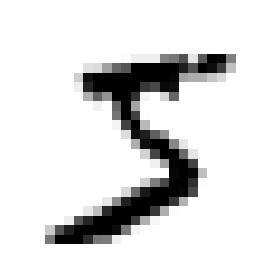

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [78]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [70]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [6]:
y[0]

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

### Set aside a test set to use later!

We can't forget to do this before we get too excited to crawl into the data.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We don't have to shuffle the dataset further because the MNIST data is already random. It's not ordered, so there's no need to shuffle. We can be confident that the training and test set is already sufficiently homogenous.

## Training a Binary Classifier

Train something to detect either '5' or 'not-5'. This will be using a **Stochastic Gradient Descent** model that we will refer to from ScitKit-Learn

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy using Cross-Validation
We're going to 'SGDClassifier' for K-Fold cross-validation for this, using k=3 folds.

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This exemplifies why 'accuracy' isn't the best way to measure classifiers, especially if you have a *skewed dataset*.

## Confusion Matrix

Idea is to count the number of times instances of 'class A' are classified as 'class B'.

We need to compute the predictions so that we actually have something to compare to the targets.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

We did pretty good. We had 687 false positives (not-5's identified as 5's), and 1891 false negatives (5's identified as not-5's).

Here's a theoretically "perfect" classifier for reference:

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

These are metrics that are used to evaluate how good the predictions are. 
* Precision measures 'True Positives' to the sum of 'True Positives' and 'False Positives'. 
* Recall measures 'True Positives' to the sum of 'True Positives' and 'False Negatives'.

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

This model doesn't look so good if it only correctly guesses 83.7%, but can only detect 65.1% of the 5's in the data set. It's insufficient.

We can combine precision and recall into a single metric called 'F_1':

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Increasing *precision* will actually reduce *recall* and vice versa. It is not possible to be perfect, this is the *precision/recall trade-off*.

## Precision/Recall Trade-off

We need to know how the SGD classifier works to better understand the issue at hand.

SGD works by:
* Computing a score based on a *decision function*.
* If it exceeds a threshold, a positive value is assigned.
* If it is below a threshold, a negative value is assigned.

For anything between these thresholds, there are a mix of true 5's and true not-5's. Any direction you slide the threshold will either improve one metric or the other, but because the decision function is naturally going to rate a not-5 as "more 5" than a true 5, there will always be some error.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

We'll use 'matplotlib' to actually plot this into something useful.

Saving figure precision_recall_vs_threshold_plot


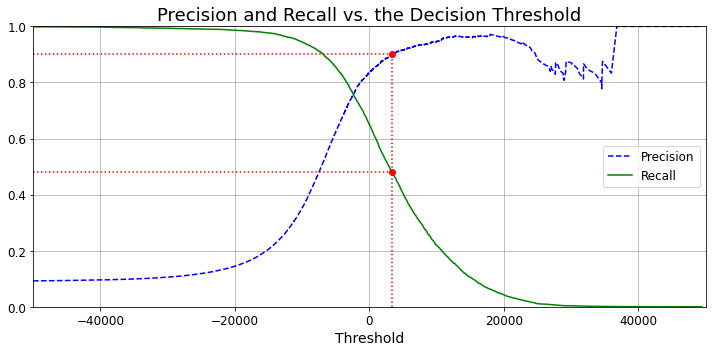

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right",fontsize=12)
    plt.title("Precision and Recall vs. the Decision Threshold", fontsize=18)
    plt.xlabel("Threshold", fontsize=14)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
    
plt.figure(figsize=(10,5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown

save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


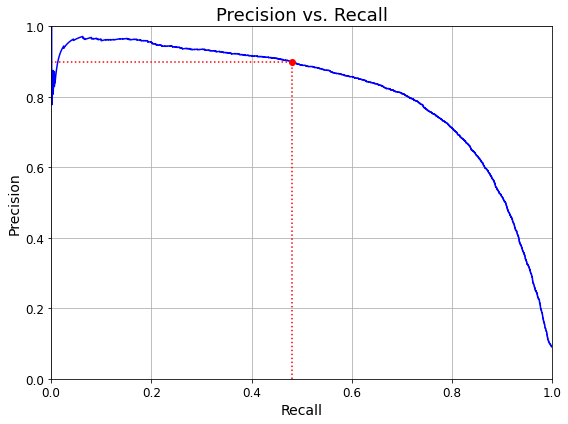

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b")
    plt.title("Precision vs. Recall", fontsize=18)
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)

plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")

plt.show()

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

ROC stands for *receiver operator characteristic* curve. It's a common tool for binary classifiers.

ROC plots *true positive rate* (recall) against the *false positive rate* (FPR). $ROC = 1 - TNR$, where TNR is the *true negative rate*.

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve


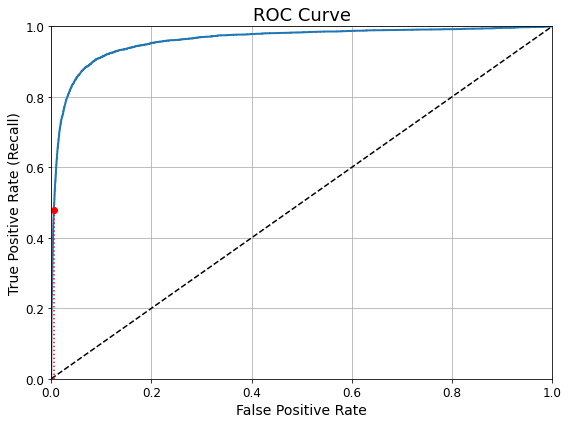

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.title("ROC Curve", fontsize=18)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown

save_fig("roc_curve")
plt.show()

One way to measure the performance based on the ROC is to use $ROC AUC$, otherwise called the ROC *area under the curve*.

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier

Let's train a Random Forest Classifier to compare the ROC curve to what we just built with Stochastic Gradient Descent.

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [34]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

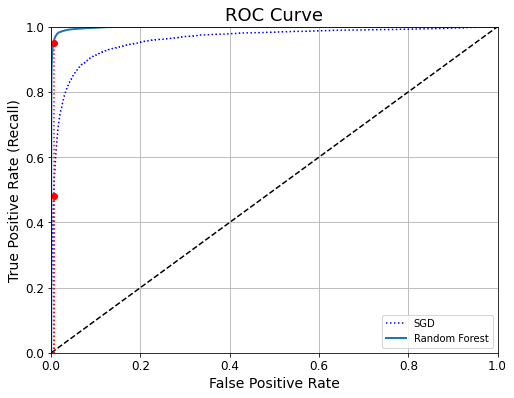

In [35]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")

plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")

plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [37]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [38]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification

Binary classifiers work for identifying binary classes (i.e. '5' or 'not-5'). A multiclass classifier can identify more classes at once.

SciKit can detect when you're running binary classification on a multiclass classification task, and will automatically run OvR or Ovo depending on the algorithm.

We'll start with a Support vector Machine classifier for now.

In [39]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5 b/c it's multiclass now
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

Conveniently the 5th index of svm_clf.classes_ matches our identified value of '5', but that won't always be the case. In the future, you might not be trying to identify characters like in the MNIST set, so reference the whole '.classes_' to see where your desired value is.

Since this used the OvO method, let's try forcing SciKit to use OvR:

In [46]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [50]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [51]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**WARNING:** If you're opening this notebook and rerunning the kernel, these last two cells in this section will take a really long time to compute (~30min).

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

Assuming this is the best model (i.e. we're going to skip trying to select a better model without tweaking), we would now move into fine-tuning the model by looking at the type of errors it's making. Let's start by plotting the confusion matrix.

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

These numbers can be hard to gather much use from, so we can also plot the matrix as an image with various grayscale values corresponding to the numbers.

Saving figure confusion_matrix_plot


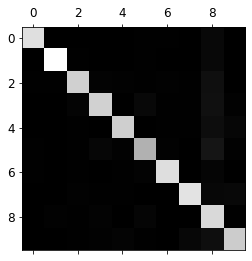

In [63]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


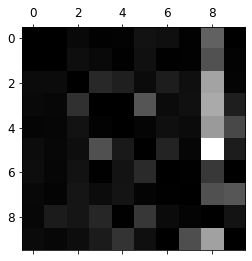

In [66]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


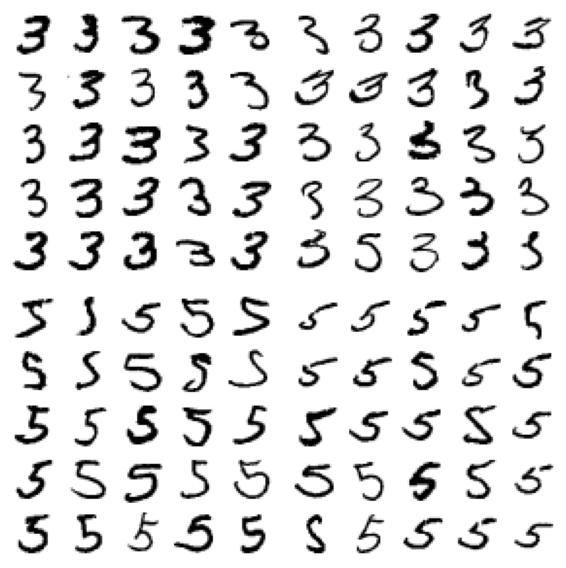

In [71]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

One possible observation here is that this model is very sensitive to the rotation and position of the digit as it's written, so some preprocessing of the source graphics could be done to make the model more accurate. Fundamentally, the issue is that SGD is a linear model, and can only assign values along a line.

# Multilabel Classification

This is when we want to test a source for multiple different labels (i.e. multiple labels could be present in the same data set). A great example of this would be a facial recognition model; it needs to identify if multiple faces are present in a photo, and output a vector of whether that class is detected or not. 

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

This output is correct! It correctly identified that 5 is not large, 'False', and that it _is_ odd, 'True'.

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

This is technically *multioutput-multiclass classification*, but we simplify it to *multiouput classification*.

You could argue that this task we're about to complete is actually regression. We're *predicting* a pixel's intensity in order to clean up an entire image.

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


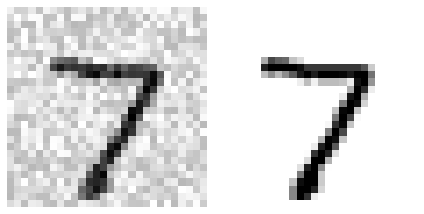

In [80]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

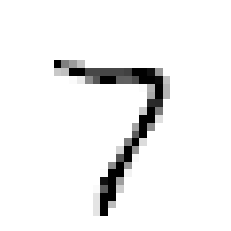

In [81]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)